<a href="https://colab.research.google.com/github/jugernaut/Prometeo/blob/desarrollo/02_AlgebraLineal/06_Normas/07_NormasInducidasAplicaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Normas Inducidas Aplicación
### Proyecto PAPIME PE101019
- Autor: Miguel Angel Pérez León
- Rev: mar oct  1 17:08:27 CDT 2020

## Introducción

El concepto de norma es de gran importancia en el contexto de los espacios vectoriales, tiene multiples aplicaciones y una de ellas es para definir metricas en dichos espacios para poder medir distancias entre los elementos que pertenecen a estos espacios vectoriales.

La distancia entre un vector y el origen o entre una matriz y otra puede tener multiples interpretaciones, en este documento veremos como el concepto de norma se aplica al campo de la inteligencia artificial y en particular en las redes neuronales.

Las redes neuronales y el aprendizaje de máquina es de las áreas de las ciencias que han tenido más desarrollo en las últimas epocas.

Y una de las áreas en las que mayor aplicación han tenido estas disciplinas es en la **clasificicación automatizada**.

Supongamos que nos interesa clasificar colores y dado que los colores se pueden ver como vectores con 3 componentes entonces podemos establecer distancias entre estos vectores para determinar que tan "similares" o "distintos" son unos de otros.

A partir de este concepto de "distancia" (norma en un espacio vectorial) podemos comenzar a clasificar cualquier cosa que pueda ser caracterizada por un vector.

## Mapa auto organizado (SOM)

Un mapa auto organizado o SOM por sus siglas en inglés (self-organized map) es una de las redes neuronales más sencilla y fáciles de implementar pero no por eso es un algoritmo que no tenga aplicación actualmente.

Este tipo de red neuronal fue creado en la decada de los 80's por el por el finlandés Teuvo Kohonen y se basa en modelos matemáticos de Alan Turing.

La idea detrás de este algoritmo es muy sencilla y se describe de manera breve a continuación:

*   Comenzamos con una red o mapa (matriz) de vectores o incluso de matrices en la cual todas las neuronas o entradas del mapa contienen valores aleatorios.
*   Por cada elemento en la lista de entrenamiento, se evalua la norma (distancia) de este elemento contra cada neurona en la red.
*   Tomamos aquella neurona cuya norma haya sido la menor y modificamos los valores de las neuronas vecinas para que se parezcan un poco al vector evaluado en esa iteración.
*   Se repite este proceso hasta terminar las iteraciones o si la norma de la red actual y la red anterior no difiere mucho.





### Formalización del algoritmo

Para dar un formalización de este algoritmo es necesario definir un conjunto de variables que son usadas durante el proceso de entrenamiento y clasificación de la red nueronal


#### Variables

*   $s$ es la iteración actual.
*   $\lambda$ cantidad de ciclos de entrenamiento o epocas.
*   $t$ es el índice del vector de entrada en el conjunto de datos de entrada $D$.
*   $D(t)$ es un vector de entrada de índice $t$ del conjunto de datos de entrada $D$.
*   $v$ es el índice de una neurona en el mapa.
*   $W_v$ es el vector de pesos de la neurona v.
*   $u$ es el índice de la neurona cuya norma es la menor con respecto de $W_v$
*   $\Theta (u,v,s)$ es la función de vecindad que determina cuáles neuronas serán modificadas.
*   $\alpha (s)$ es una función que restringe el aprendizaje conforme avanzan las iteraciones.

#### Algoritmo

1.   Hacer un mapa (red) de neuronas con vectores de pesos aleatorios.
2.   Tomar un vector de entrada $D(t)$.

>1.   Iterar por cada neurona del mapa.

>>1.   Calcular la distancia entre el vector de entrada y los vectores de pesos de las neuronas del mapa.
2.   Mantener la neurona que ha tenido la menor distancia (norma), esta neurona será el best matching unit (BMU).

>2.   Actualizar las neuronas en la vecindad del BMU.

>> 1.   $W_{v}\left(s+1\right)=W_{v}\left(s\right)+\Theta\left(u,v,s\right)\alpha\left(s\right)\left(D\left(t\right)-W_{v}\left(s\right)\right)$

3.   Incrementar $s$ y volver al paso 2, mientras $s<\lambda$.




## Tensor Flow

Tensor Flow es un API desarrollado por Google que tiene la finalidad de facilitar la implementación de redes neuronales.

Se usa en multiples aplicaciones de Google como su **reconocimiento automatizado de imagenes** en el buscador o en el **reconocimiento de patrones de voz** para su asistente virtual.

Existen versiones de Tensor Flow optimizadas para hacer uso de GPU's (unidades de procesamiento grafico) o incluso de TPU's (unidades de procesamiento tensorial).

Actualmente se encuentra en su versión 2.3 sin embargo para el ejemplo que veremos haremos uso de la versión 1.1.

Su funcionamiento es muy intuitivo y se recomienda revisar su [documentación](https://www.tensorflow.org/api_docs) para una mayor comprensión del código mostrado a continuación

## Implementación

Para tener una mejor organización del algoritmo y mediante el paradigma orientado a objetos, se crea la **clase SOM** que encapsula las acciones que podemos llevar a cabo con un SOM.

El código ha sido comentado para su mejor comprensión pero de manera general implementa el algoritmo descrito previamente.

In [1]:
!pip install tensorflow==1.1
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
#%tensorflow_version 1.x
 
class SOM(object):
    """
    Clase que representa una red neuronal tipo SOM.
    """
 
    #Para revisar si la red ya ha sido entrenada
    _trained = False
 
    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):
        """
        Constructor que toma como parametros los valores descritos en el
        algoritmo SOM. Genera un mapa de m renglones por n columnas y se entrenara
        con n_iterations
        """
 
        #Se inicializan variables que seran usadas a lo largo del coidgo
        self._m = m
        self._n = n
        if alpha is None:
            alpha = 0.3
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self._n_iterations = abs(int(n_iterations))
 
        '''SE NECESITA UNA GRAFICA (PLANO), hay una grafica
        por default pero la guardamos en _graph'''
        self._graph = tf.Graph()
 
        '''SE CREAN LOS ELEMENTOS NECESARIOS EN LA GRAFICA'''
        with self._graph.as_default():
            '''SE CREAN TODAS LAS NEURONAS CON tf.Variable, son m*n
            neuronas con dim pesos, que seran comparados con los pesos
            de la entrada y la que tenga la menor distancia sera la
            neurona ganadora. Antes de iniciar el entrenamiento, hay
            hay que inicializar TODAS las variables'''
            
            '''Lista de pesos de los vectores de la red neuronal'''
            self._weightage_vects = tf.Variable(tf.random_normal(
                [m*n, dim]))
 
            '''Lista de 600 entradas, y cada entrada representa una
            coordenada en la cual se encuentra cada neurona'''
            self._location_vects = tf.constant(np.array(
                list(self._neuron_locations(m, n))))
 
            '''self._vect_input es un placeholder de tamano dim, ya que
            es el objeto que sera alimentado con el vector de entrada y
            a su vez este sera comparado con los pesos de cada neurona.
            Esto es asi por el framework que da tensorflow'''
            self._vect_input = tf.placeholder("float", [dim])
            
            '''Lo mismo sucede con esta variable, la diferencia es que en
            este punto aun no se sabe cuantas iteraciones (epocas) seran
            necesarias, asi que se deja en cero.'''
            self._iter_input = tf.placeholder("float")
 
            '''Devuelve el indice con el menor valor, es decir la neurona mas cercana.'''
            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self._weightage_vects, tf.stack(
                    [self._vect_input for i in range(m*n)])), 2), 1)),
                                  0)
 
            '''Variable que guarda el indice y un espacio para el sus
            coordenada'''
            slice_input = tf.pad(tf.reshape(bmu_index, [1]),
                                 np.array([[0, 1]]))
            bmu_loc = tf.reshape(tf.slice(self._location_vects, slice_input,
                                          tf.constant(np.array([1, 2]))),
                                 [2])
 
            '''Valores necesario para actualizar los pesos de las neuronas
            de acuerdo a la iteracion (epoca)'''
            learning_rate_op = tf.subtract(1.0, tf.div(self._iter_input,
                                                  self._n_iterations))
            _alpha_op = tf.multiply(alpha, learning_rate_op)
            _sigma_op = tf.multiply(sigma, learning_rate_op)
 
            '''Calcula las distancias al cuadrado por cada neurona con respecto
            a la neurona GANADORA (BMU). De tal manera que estos valores
            puedan ser empleados para actualizar los pesos de los vecinos'''
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(
                self._location_vects, tf.stack(
                    [bmu_loc for i in range(m*n)])), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(
                bmu_distance_squares, "float32"), tf.pow(_sigma_op, 2))))
            learning_rate_op = tf.multiply(_alpha_op, neighbourhood_func)
 
            '''Tasa de aprendizaje para actualizar los pesos de las neuronas'''
            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), np.array([1])), [dim])
                                               for i in range(m*n)])
            weightage_delta = tf.multiply(
                learning_rate_multiplier,
                tf.subtract(tf.stack([self._vect_input for i in range(m*n)]),
                       self._weightage_vects)) 
            
            '''Actualiza todos los pesos de las neuronas de acuerdo a los
            parametros calculados previamente'''                                        
            new_weightages_op = tf.add(self._weightage_vects,
                                       weightage_delta)
            
            '''Se guarda la ultima operacion realizada en la SOM, ya que
            esta operacion sera la que se ejecute y a su vez ejecuta todas
            las operaciones previar al llamar a sess.run()'''
            self._training_op = tf.assign(self._weightage_vects,
                                          new_weightages_op)                                       
 
            '''En tensorflow todo debe ocurrir dentro de una sesion, es por
            este motivo que se guarda la sesion'''
            self._sess = tf.Session()
 
            '''Forma en la tensorflow inicializa sus variables antes de ser
            utilizadas'''
            init_op = tf.initialize_all_variables()
            self._sess.run(init_op)
            
            '''centroid_grid es un mapa de bits en el cual se guardan los
            valores de las neuronas. Es de tamano m, por que para cada renglon
            se tienen n neuronas y sus respectivos valores. '''
            centroid_grid = [[] for i in range(self._m)]
            self._weightages = list(self._sess.run(self._weightage_vects))
            self._locations = list(self._sess.run(self._location_vects))
    
            '''Con este for, se accede a cada neurona por posicion y se guarda
            en centroid_grid sus pesos. El resultado es un mapa de bits que puede
            ser facilmente graficado por matplotlib. Es el mapa incial (SIN ENTRENAR)'''
            for i, loc in enumerate(self._locations):
                centroid_grid[loc[0]].append(self._weightages[i])
            self._mapa_inicial = centroid_grid
 
    def _neuron_locations(self, m, n):
        '''Yield regresa un generador flojo, y hasta que es necesario
        se evalua. Esto se hace para que no haya informacion no necesaria
        en memoria. En el constructor el resultado de esta funcion se
        mete en una lista para que sea accesible de inmediato'''
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])
 
    def train(self, input_vects):
        '''Para cada iteracion (epoca) se realiza el entrenamiento'''
        for iter_no in range(self._n_iterations):
            actual = self._sess.run(tf.norm(self._weightage_vects))
            #Se entrena con cada vector uno por uno
            for input_vect in input_vects:
                self._sess.run(self._training_op,
                               feed_dict={self._vect_input: input_vect,
                                          self._iter_input: iter_no})
            siguiente = self._sess.run(tf.norm(self._weightage_vects))
            '''Si la norma del mapa actual no varia mucho con respecto
            al siguiente, se rompe el ciclo de las epocas'''
            if abs(siguiente - actual) <= 0.000001:
                break
 
        '''centroid_grid es un mapa de bits en el cual se guardan los
            valores de las neuronas. Es de tamano m, por que para cada renglon
            se tienen n neuronas y sus respectivos valores. '''
        centroid_grid = [[] for i in range(self._m)]
        self._weightages = list(self._sess.run(self._weightage_vects))
        self._locations = list(self._sess.run(self._location_vects))
        
        '''Con este for, se accede a cada neurona por posicion y se guarda
            en centroid_grid sus pesos. El resultado es un mapa de bits que puede
            ser facilmente graficado por matplotlib. En este punto la red ya esta entrenada.'''
        for i, loc in enumerate(self._locations):
            centroid_grid[loc[0]].append(self._weightages[i])
        self._centroid_grid = centroid_grid
 
        '''En este punto la red ya esta entrenada.'''
        self._trained = True
 
    def get_centroids(self):
        # Solo devuelve los centroides para que puendan ser graficados
        if not self._trained:
            raise ValueError("La red aun no ha sido entrenada")
        return self._centroid_grid
 
    def map_vects(self, input_vects):
        '''to_return es la lista que contiene las coordenadas (x,y) de la
        neurona que mas se parece a cada una de las entradas de input_vects
        en el mismo orden'''
 
        if not self._trained:
            raise ValueError("SOM not trained yet")
 
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self._weightages))],
                            key=lambda x: np.linalg.norm(vect-
                                                         self._weightages[x]))
            to_return.append(self._locations[min_index])
 
        return to_return
    
    def map_vect(self, vect):
        '''
        Mapea un solo vector y devuelve la clasificacion vista como
        un indice relacionado a la coordenada (x,y) de la neurona
        '''

        min_index = min([i for i in range(len(self._weightages))],
                        key=lambda x: np.linalg.norm(
                            vect - self._weightages[x]))
        pos2D = self._locations[min_index]
        # polinomio de direccionamiento de la neurona
        #return pos2D[0]*self._m + pos2D[1], pos2D
        return (pos2D[1], pos2D[0])

     |████████████████████████████████| 31.4MB 146kB/s 
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:455: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:456: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:457: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or 

### Métodos relevantes

Todo el código escrito para la clase SOM tiene un objetivo en específico sin embargo para fines prácticos nos enfocaremos en un par de métodos que tienen relación directa con el concepto de norma.

#### Método *train*

Este método se encarga de realizar el ciclo de entrenamiento de la red neuronal, en este método se compara cada uno de los vectores de entrada contra todas las neuronas de la red.

Una vez que se localiza la BMU se actualizan los pesos de las neuronas vecinas empleando la funcion de vecindad y la funcion de aprendizaje.

El entrenamiento concluye una vez que han terminado las iteraciones o epocas, aunque también se concluye el entrenamiento si las redes en la iteración actual y en la siguiente no difieren demasiado y eso lo sabemos **calculando la norma a ambas redes**.

#### Método *map_vect*

Este método es el encargado de recibir un vector y devolvernos la neurona (en forma de coordenada dentro del mapa) cuya distancia (empleando la norma) sea la menor, eso significa que esa neurona es la más parecida al vector de entrada, en otras palabras obtenemos la clasificación del vector que le mostramos a la red.

Si conocemos el nombre o identificador de la neurona que se parece al vector de entrada podemos asignarle esa clasificación al vector de entrada.

En esta implementación se usan colores, de manera que al mostrar un color en forma de vector (R, G, B) esta red nos indica a que color se parece mas un vector.

## Ejecución

Se define una lista de colores en formato RGB (red blue green) para entrenar a la red neuronal. De igual manera se crea una lista con los nombres de los colores en la lista de colores.

Se genera un objeto de tipo SOM con sus respectivos parametros.

Mostramos la red inicial con colores aleatorios.

Se entrena la red de acuerdo a la descripción del algoritmo y a las restricciones del mismo.

Posteriormente se muestra la red entrenada.

Finalmente se le muestra un color en forma de vector a la red neuronal ya entrenada y esta devuelve un par de coordenadas, lo que en otras palabras significa que nos vevuelve las coordenadas de la neurona que se parece más al color mostrado. Es decir, nos devuelve una clasificación del color mostrado.

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


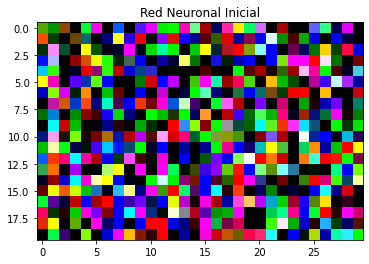

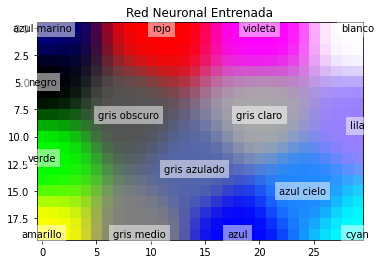

El color azul cielo se encuentra en la neurona (24, 15)


In [2]:
import numpy as np
from matplotlib import pyplot as plt
 
# Vectores de entrenamiento RGBcolors
colores = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
nombres_colores = \
    ['negro', 'azul', 'azul marino', 'azul cielo',
     'gris azulado', 'lila', 'verde', 'rojo',
     'cyan', 'violeta', 'amarillo', 'blanco',
     'gris obscuro', 'gris medio', 'gris claro']
 
# Creamos un SOM de 20x30, cada entrada de la red
# es un vector de tamano 3 (R,G,B) y se entrena 400 veces
som = SOM(20, 30, 3, 400)

# Se muestra el mapa inicial
mapa_inicial = som._mapa_inicial
plt.imshow(mapa_inicial)
plt.title('Red Neuronal Inicial')
plt.show()

# Se entrena la red con un conjunto de colores
som.train(colores)
 
# Obtenemos el SOM ya entrenado
red_entrenada = som.get_centroids()
 
# Contiene la lista de coordenadas de los correspondientes colores
mapped = som.map_vects(colores)
 
# Grafica
plt.imshow(red_entrenada)
plt.title('Red Neuronal Entrenada')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], nombres_colores[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.show()

# Se le muestra un color en forma de vector, en este caso azul cielo
# para que indique a que neurona se parece mas
print("El color azul cielo se encuentra en la neurona "+str(som.map_vect([0.125, 0.529, 1.0])))



### Mostrando mas colores

Una vez que la red (mapa) ya fue entrenada, es posible mostrarle cualquier color en forma de vector (R,G,B) y la red nos mostrara que clasificación le corresponde, por ejemplo.

In [3]:
print("El color amarillo se encuentra en la neurona "+str(som.map_vect([1., 1., 0.])))


El color amarillo se encuentra en la neurona (0, 19)


## Extendiendo este modelo

La implementación en este documento se realizo con colores, ya que facilitan la comprensión del funcionamiento del algoritmo en general.

Sin ambargo esta red neuronal puede ser aplicada a cualquier espacio vectorial, en otras palabras, este algoritmo puede ser aplicado a cualquier objeto que podamos representar en forma de vector o matriz.

### Clasificación de Documentos o Imágenes

Para clasificar documentos el algoritmo es exactamente el mismo, lo único que cambia es que tenemos que obtener un **vector caracteristico** para los documentos que nos interes clasificar. Este vector caracteristico se puede obtener de formas muy variadas y una de ellas es **contando la frecuencia de las plabras** que aparecen en dicho documento.

Respecto a la clasificación de imágenes, una imagen finalmente es un **mapa de pixeles**, mismo que puede ser representado por un vector de vectores, es decir un **vector de colores**, lo que en si ya un vector caracteristico de dicha imágen.

## Referencias

*   https://codesachin.wordpress.com/2015/11/28/self-organizing-maps-with-googles-tensorflow/
*   http://www.saedsayad.com/clustering_som.htm
*   https://www.tensorflow.org/install
*   https://relopezbriega.github.io/blog/2016/06/05/tensorflow-y-redes-neuronales/

